Capstone 2: Exploratory Data Analysis
This notebook will be perform Exploratory Data Analysis on the processed UK retail data. See the notebook "raw-uk-retail-cleaning.ipynb" for an explanation on how the raw data was cleaned into the data set used in this notebook.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fileName = '../data/processed/processedUkData.csv'

In [3]:
df = pd.read_csv(fileName,index_col=[0], parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360166 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    360166 non-null  int64         
 1   StockCode    360166 non-null  object        
 2   Description  360166 non-null  object        
 3   Quantity     360166 non-null  int64         
 4   InvoiceDate  360166 non-null  datetime64[ns]
 5   UnitPrice    360166 non-null  float64       
 6   CustomerID   360166 non-null  int64         
 7   Country      360166 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 24.7+ MB


Questions that we may be able to answer through exploring this data:
1. What is the average revenue per transaction?
2. What is the average quantity purchased per customer?

I'll create a new column, "revenue", that is the quantity multiplied by the unit price. This revenue feature will be the variable that I try to predict using the other features as I believe it will be a good indicator for determining the most valued customer, and highest sold product.

In [5]:
revenue = df['Quantity'] * df['UnitPrice']
df.insert(len(df.columns), 'revenue', revenue)

The InvoiceNo column will be dropped since it a arbitrary value assigned by the retail store that I don't want to affect the prediction models I'll be using later.

In [6]:
df = df.drop(columns=['InvoiceNo'])


In [7]:
df.shape

(360166, 8)

In [8]:
df.head(3)

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00


In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID,revenue
count,360166.000000,360166.000000,360166.000000,360166.000000
mean,13.388529,2.886688,15457.805070,22.701969
std,189.510089,4.466709,1634.685138,323.909628
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,14156.000000,4.560000
50%,5.000000,1.950000,15382.000000,11.700000
75%,12.000000,3.750000,16904.000000,19.800000
max,80995.000000,649.500000,18287.000000,168469.600000


From the summary of the data we see the mean for quantity and unit price are extremely low compared to the maximum value in each feature. We also see the majority of data is also well below the maximum values in each category.

In [10]:
#defining an empirical cummutive distributuion function in order to see how much of our data lies in what percentile.
#function accepts a data series and returns a tuple containing the ordered series and percentile series
def ecdf(series):
    ordered = np.sort(series)
    percentage = np.arange(1,len(ordered)+1)/len(ordered)
    
    return (ordered, percentage)
    

In [11]:
quantity_ecdf = ecdf(df['Quantity'])

In [12]:
quantity_ecdf

(array([    1,     1,     1, ..., 12540, 74215, 80995], dtype=int64),
 array([2.77649750e-06, 5.55299501e-06, 8.32949251e-06, ...,
        9.99994447e-01, 9.99997224e-01, 1.00000000e+00]))

Text(0.5, 1.0, 'Quantity ECDF')

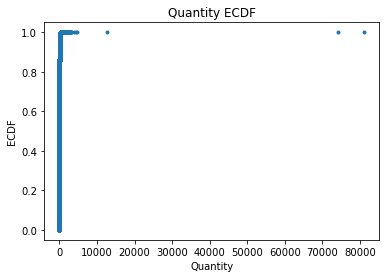

In [23]:
plt.plot(quantity_ecdf[0], quantity_ecdf[1], marker='.', linestyle='none')
plt.xlabel('Quantity')
plt.ylabel('ECDF')
plt.title('Quantity ECDF')

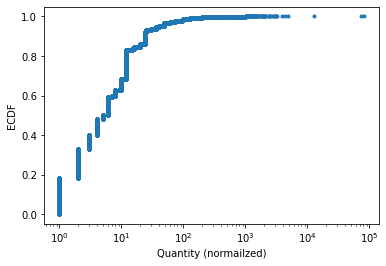

In [24]:
#A normalized version of the plot above.
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(quantity_ecdf[0], quantity_ecdf[1], marker='.', linestyle='none')
ax.set_xscale('log')
ax.set_xlabel('Quantity (normailzed)')
ax.set_ylabel('ECDF')
plt.show()

Text(0.5, 1.0, 'Unit Price ECDF')

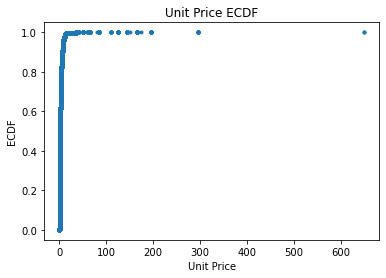

In [14]:
price_ecdf = ecdf(df['UnitPrice'])

plt.plot(price_ecdf[0], price_ecdf[1], marker='.', linestyle='none')
plt.xlabel('Unit Price')
plt.ylabel('ECDF')
plt.title('Unit Price ECDF')

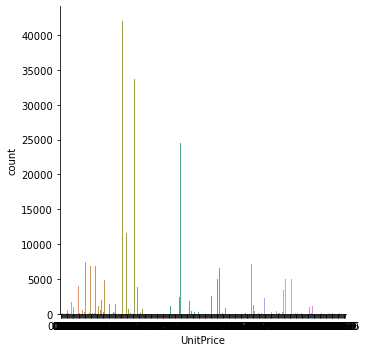

In [15]:
sns.catplot(kind='count', data=df, x='UnitPrice', y=None)

After some thought revenue may not be the best feature to predict. Since revenue is calculated from the unit price and quantity, it would be redundant to include them as independent variables in our prediction models. That leaves us with the StockCode/Description, InvoiceDate, CustomerID, and Country as the basis of our prediction model. We can run into a situation where the exact same values for the independent variables generates completely different revenue values. An example, a red shirt with an invoice date of 1/1/2010 bought in the UK could have revenue of \\$5, but it is also possible with those same independent parameters that revenue of \\$500 is generated. 

So maybe the better questions to explore are:
1. Which product is consistency bought, if any.
2. On average, how much does each product generate in revenue?
3. Can we look at price, product, and location to predict quantity needed to meet demand?
4. Which product is demanded by the greatest number of people?

In [39]:
df.groupby(['StockCode','Description'])[['Quantity']].sum()

,,Quantity
StockCode,Description,
10002,INFLATABLE POLITICAL GLOBE,667
10080,GROOVY CACTUS INFLATABLE,290
10120,DOGGY RUBBER,192
10123C,HEARTS WRAPPING TAPE,5
10124A,SPOTS ON RED BOOKCOVER TAPE,16
...,...,...
90214U,"LETTER ""U"" BLING KEY RING",12
90214V,"LETTER ""V"" BLING KEY RING",14
90214W,"LETTER ""W"" BLING KEY RING",12


It appears there are transaction that may not be related to product sales, "Bank Charges" and "CARRIAGE", that were missed during the data cleaning. They will be stored and removed from our data set for now.

In [17]:
#Saving the transactions not related to product purchases.
bank_charges = df[df['StockCode'] == 'BANK CHARGES']
carriage = df[df['StockCode'] == 'C2']

In [18]:
#Removing the transactions not related to product purchaes.
df = df[(df['StockCode'] != 'BANK CHARGES') & (df['StockCode'] != 'C2')]

In [19]:
#Groups the df by product then sums the quantity purchased and revenue generated.
#The Quantity column is the sum of all purchases of a product, the UnitPrice column is the mean price, and the revenue column is the sum of revenues generated.
df_byProduct = df.groupby(['StockCode', 'Description']).agg({'Quantity': np.sum, 'UnitPrice': np.mean, 'revenue': np.sum})
df_byProduct.head()

,,Quantity,UnitPrice,revenue
StockCode,Description,,,
10002,INFLATABLE POLITICAL GLOBE,667,0.850,566.95
10080,GROOVY CACTUS INFLATABLE,290,0.413,114.02
10120,DOGGY RUBBER,192,0.210,40.32
10123C,HEARTS WRAPPING TAPE,5,0.650,3.25
10124A,SPOTS ON RED BOOKCOVER TAPE,16,0.420,6.72


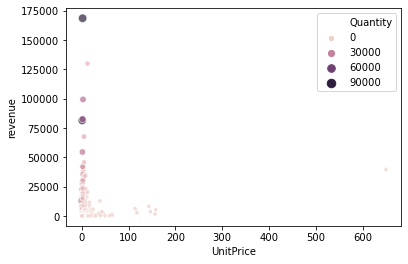

In [25]:
sns.scatterplot(data=df_byProduct, x='UnitPrice', y='revenue', hue='Quantity', size='Quantity', alpha=0.7)

In [37]:
#Correlation of from the cleaned transactions data.
df[['Quantity', 'UnitPrice','revenue']].corr()

,Quantity,UnitPrice,revenue
Quantity,1.000000,-0.018993,0.911480
UnitPrice,-0.018993,1.000000,0.069024
revenue,0.911480,0.069024,1.000000


In [26]:
#Correlation by product
df_byProduct.corr()

,Quantity,UnitPrice,revenue
Quantity,1.000000,-0.051536,0.754356
UnitPrice,-0.051536,1.000000,0.112014
revenue,0.754356,0.112014,1.000000


We see there is very little correlation between Quantity and Unit price. The same is true for unit price and revenue. There appears to be a strong correlation between revenue and quantity which suggets that lost cost products tend to generate the most revenue. This is backed by the ECDF and scatter plot above.

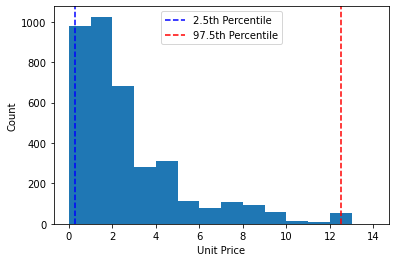

In [73]:
plt.hist(df_byProduct['UnitPrice'], bins=np.arange(0,15,1))
plt.axvline(np.percentile(df_byProduct['UnitPrice'], 2.5), color='b',linestyle='dashed', label='2.5th Percentile')
plt.axvline(np.percentile(df_byProduct['UnitPrice'],97.5), color='r',linestyle='dashed', label='97.5th Percentile')
plt.xlabel("Unit Price")
plt.ylabel("Count")
plt.legend()
plt.show()

The histogram shows that 95% of products have average unit prices below \\$15 but there are products that have average unit prices much greater than what is shown above, with one product having an average unit price of nearly \\$650. Along with the scatter plot and correlation table above, there is reason to believe that inexpensive products sell the most and generate the most revenue.

<h3>A question this data set may not be able to provide insight on.</h3>
<b>Note to self, do some of the higher priced items attract customer and eventually lead them to purchasing other items?<b>

In [48]:
df_byCustomer_total = df.groupby('CustomerID').agg({'CustomerID': np.size,'Quantity': np.sum, 'revenue':np.sum})

In [61]:
df_byCustomer_total.describe()

,CustomerID,Quantity,revenue
count,4089.000000,4089.000000,4089.000000
mean,88.081683,1179.284177,1999.627643
std,210.091804,5124.692762,9060.561457
min,1.000000,1.000000,0.000000
25%,16.000000,152.000000,298.410000
50%,40.000000,365.000000,647.790000
75%,98.000000,950.000000,1579.120000
max,7266.000000,192303.000000,271343.300000


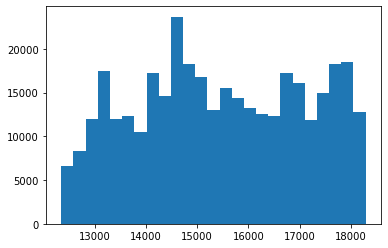

In [60]:
plt.hist(df['CustomerID'], bins = 25)
plt.show()

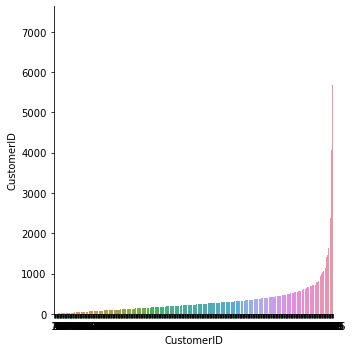

In [53]:
sns.catplot(kind='bar', data= df_byCustomer_total, x='CustomerID', y='CustomerID')

In [45]:
df_byCustomer_avg = df.groupby('CustomerID').agg({'CustomerID': np.size,'Quantity': np.mean, 'revenue': np.mean})

In [46]:
df_byCustomer_avg

,CustomerID,Quantity,revenue
CustomerID,,,
12346,1,74215.000000,77183.600000
12347,182,13.505495,23.681319
12352,22,7.318182,18.946818
12353,4,5.000000,22.250000
12354,58,9.137931,18.610345
...,...,...,...
18280,10,4.500000,18.060000
18281,7,7.714286,11.545714
18282,12,8.583333,14.837500


In [47]:
df[df['CustomerID'] == 12347].shape

(182, 8)